# Import Library

In [132]:
! pip install pykeops

In [133]:
import pandas as pd 
import torch 
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import warnings
import random
import torch 
from torch import nn

import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaConfig

warnings.filterwarnings('ignore')

In [134]:
DATA_PATH = "../input/news-topic/sample.json"
MODEL_PATH = "../input/robertalarge"
DEVICE = "cuda"
BATCH_SIZE = 8

# Read data

In [135]:

df = pd.read_json(DATA_PATH)
df = df['response']['docs']

df =pd.DataFrame(df)
df_head = pd.DataFrame( df['headline'] )
df_abstract = pd.DataFrame( np.asarray(df['abstract']), columns = ["abstract"] ) 
print("\n")
print(df_head.head)
print("\n")
print(df_abstract.head)



<bound method NDFrame.head of                                                headline
0     {'main': 'Ideal, Perfect, Ultimate: What Drive...
1     {'main': 'In Lebanon, Macron Dangles Sanctions...
2     {'main': 'Biden Campaign Courts the Animal Cro...
3     {'main': 'Corrections: Sept. 3, 2020', 'kicker...
4     {'main': 'A House panel plans to subpoena Loui...
...                                                 ...
3273  {'main': 'Southern California Battles Fires', ...
3274  {'main': 'Pakistan Universities and High Schoo...
3275  {'main': 'Japan’s New Prime Minister Meets Emp...
3276  {'main': 'Former Nissan Executive Greg Kelly A...
3277  {'main': 'Firefighters in California and Orego...

[3278 rows x 1 columns]>


<bound method NDFrame.head of                                                abstract
0     Working parents toggle constantly among compet...
1     President Macron of France met with Lebanese l...
2     Past candidates have tried to capitalize on po...
3     Correcti

In [136]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
            vocab_file= os.path.join(MODEL_PATH, "vocab.json"),
            merges_file= os.path.join(MODEL_PATH, "merges.txt"),
            lowercase=True,
            add_prefix_space=True)
# define tokenizer

In [137]:
df_abstract = np.squeeze( np.asarray(df_abstract) )
df_abstract = [" " + " ".join(df_abstract[i].lower().split()) for i in range(0,len(df_abstract))]
ids = [ tokenizer.encode(text).ids for text in df_abstract ]

max_len_ids = max( [len(x) for x in ids])
print("max length of ids = ", max_len_ids, '\n')
for i in range(0,2):
    print("text :", df_abstract[i])
    print("ids :", ids[i])
    print("---------------------------------------------")
    
print("num of datapoints",len(df_abstract))

max length of ids =  97 

text :  working parents toggle constantly among competing commitments, but many don’t want to do less; they want to do it all, better.
ids : [447, 1041, 23012, 5861, 566, 5468, 9116, 6, 53, 171, 218, 17, 27, 90, 236, 7, 109, 540, 131, 51, 236, 7, 109, 24, 70, 6, 357, 4]
---------------------------------------------
text :  president macron of france met with lebanese leaders to demand changes to a political system seen as ineffective and corrupt, and has privately threatened them with sanctions, officials said.
ids : [394, 13418, 2839, 9, 6664, 2389, 1145, 19, 2084, 7384, 4468, 917, 7, 1077, 1022, 7, 10, 559, 467, 450, 25, 21223, 8, 10334, 6, 8, 34, 9638, 3711, 106, 19, 2637, 6, 503, 26, 4]
---------------------------------------------
num of datapoints 3278


# Data Loader 

In [138]:
def data_modify(ids, max_len):
    ids_pad = [0] + ids + [2]
                
    pad_len = max_len - len(ids_pad) + 2 # add two for special tokens (start and end)
    if pad_len > 0: # pad one 
        ids_pad += [1] * pad_len
    
    ids_pad = torch.tensor(ids_pad)
    masks = torch.where(ids_pad != 1, torch.tensor(1), torch.tensor(0))
    

    return ids_pad, masks
    


class NewsDataset(torch.utils.data.Dataset):
    # read text,
    # get the input of roberta model 
    
    def __init__(self, text, ids, max_len_ids=99):
        self.max_len_ids = max_len_ids # max length of ids 
        self.text = text 
        self.ids = ids

        
        self.length = len(self.text) # number of datapoints

    def __getitem__(self, index):
        data_point = {}

        

        text_, ids_ = self.text[index], self.ids[index] 

        ids_pad , masks = data_modify( ids_, self.max_len_ids ) # return padding ids and masks 
        
#         data_point['text'] = text_
        data_point['ids'] = ids_pad             
        data_point['masks'] = masks  
        data_point['text'] = text_

        
        return data_point
    def __len__(self):
        return self.length




def get_train_dataloader(df, batch_size = 8):
    data_loader = torch.utils.data.DataLoader( NewsDataset(df), batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = False )
    
    return data_loader 




# construct dataloader 
dataloader = torch.utils.data.DataLoader( NewsDataset(df_abstract, ids, max_len_ids), batch_size = BATCH_SIZE, shuffle = False, num_workers = 2, drop_last = False )

In [139]:
for i,data in enumerate(dataloader):
    print("\n i = ",i)
    if( i> 1): break
    print()
    ids = data['ids'][0]
    masks = data['masks'][0]
    print(ids,'\n', masks,'\n','\n')



 i =  0

tensor([    0,   447,  1041, 23012,  5861,   566,  5468,  9116,     6,    53,
          171,   218,    17,    27,    90,   236,     7,   109,   540,   131,
           51,   236,     7,   109,    24,    70,     6,   357,     4,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1]) 
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

 # Feature extraction

use pretrained roberta to extract feature vector 

In [140]:
# text -> encoding -> (roberta model) -> vector 

class pre_trained_roberta(nn.Module):
    def __init__(self):
        super(pre_trained_roberta, self).__init__()
        
        config = RobertaConfig.from_pretrained(
            os.path.join(MODEL_PATH, "config.json"), output_hidden_states=True)    
        self.roberta = RobertaModel.from_pretrained(
            os.path.join(MODEL_PATH, "pytorch_model.bin"), config=config)
    
        

    def forward(self, input_ids, attention_mask):
        _, _, y = self.roberta(input_ids, attention_mask) # hidden states 
         
#         x = torch.cat((y[-1], y[-2]), dim=-1) # feature vector 
        x = torch.sum( y[-1] + y[-2]+y[-3]+y[-4], dim = 1 )  # feature vector 
        # shape = [n_batch, length_of_sentenct, dim_hidd]

        # extract the ouput of the final n hidden layers 
        
        return x 


In [141]:
model = pre_trained_roberta()
model.to(DEVICE)

pre_trained_roberta(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm(

In [142]:
N = 3278 # number of data point 
D =  1024 # dim of feature vectors 

model.eval() # evaluation mode 
feature_tensor = torch.zeros((N,D))

it = 0
for data in (dataloader):
    ids = data['ids'].to(DEVICE)
    masks = data['masks'].to(DEVICE)
                
    with torch.no_grad():
        feature = model(ids, masks)
        feature_tensor[ it:it+len(feature), :] = feature 
        
        it = it+feature.shape[0]
        if( it % (feature.shape[0] * 100) == 0 ):
            print(" read %",100 *  it/N)
            


 read % 24.405125076266017
 read % 48.810250152532035
 read % 73.21537522879805
 read % 97.62050030506407


In [143]:
# normalize feature vector
mean = torch.mean(feature_tensor, dim=0)
std = torch.sqrt( torch.var( feature_tensor, dim=0))
feature_tensor = (feature_tensor - mean)/std

# Clustering
 Using Kmeans to do the clustering



In [144]:
# EM learnign of K means algo from https://www.kernel-operations.io/keops/_auto_tutorials/kmeans/plot_kmeans_torch.html

import time 
from pykeops.torch import LazyTensor
def KMeans(x, K=10, Niter=10, verbose=True):
    
    dtype = 'float32' if DEVICE == 'cuda' else 'float64'
    torchtype = {'float32': torch.float32, 'float64': torch.float64}
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[:K, :].clone()  # Simplistic random initialization
    x_i = LazyTensor(x[:, None, :])  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = LazyTensor(c[None, :, :])  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torchtype[dtype])  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

In [163]:
K =10
cl,c = KMeans(feature_tensor ,K = K, Niter = 20)

K-means example with 3,278 points in dimension 1,024, K = 10:
Timing for 20 iterations: 1.60143s = 20 x 0.08007s



# Show clustering result with Umap

In [164]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [165]:
# transform the data (umap)

plot_feature = feature_tensor.cpu().numpy()
plot_class = cl.cpu().numpy()

sns.set(style='white', rc={'figure.figsize':(20,20)})
standard_embedding = umap.UMAP(random_state=42).fit_transform(plot_feature)


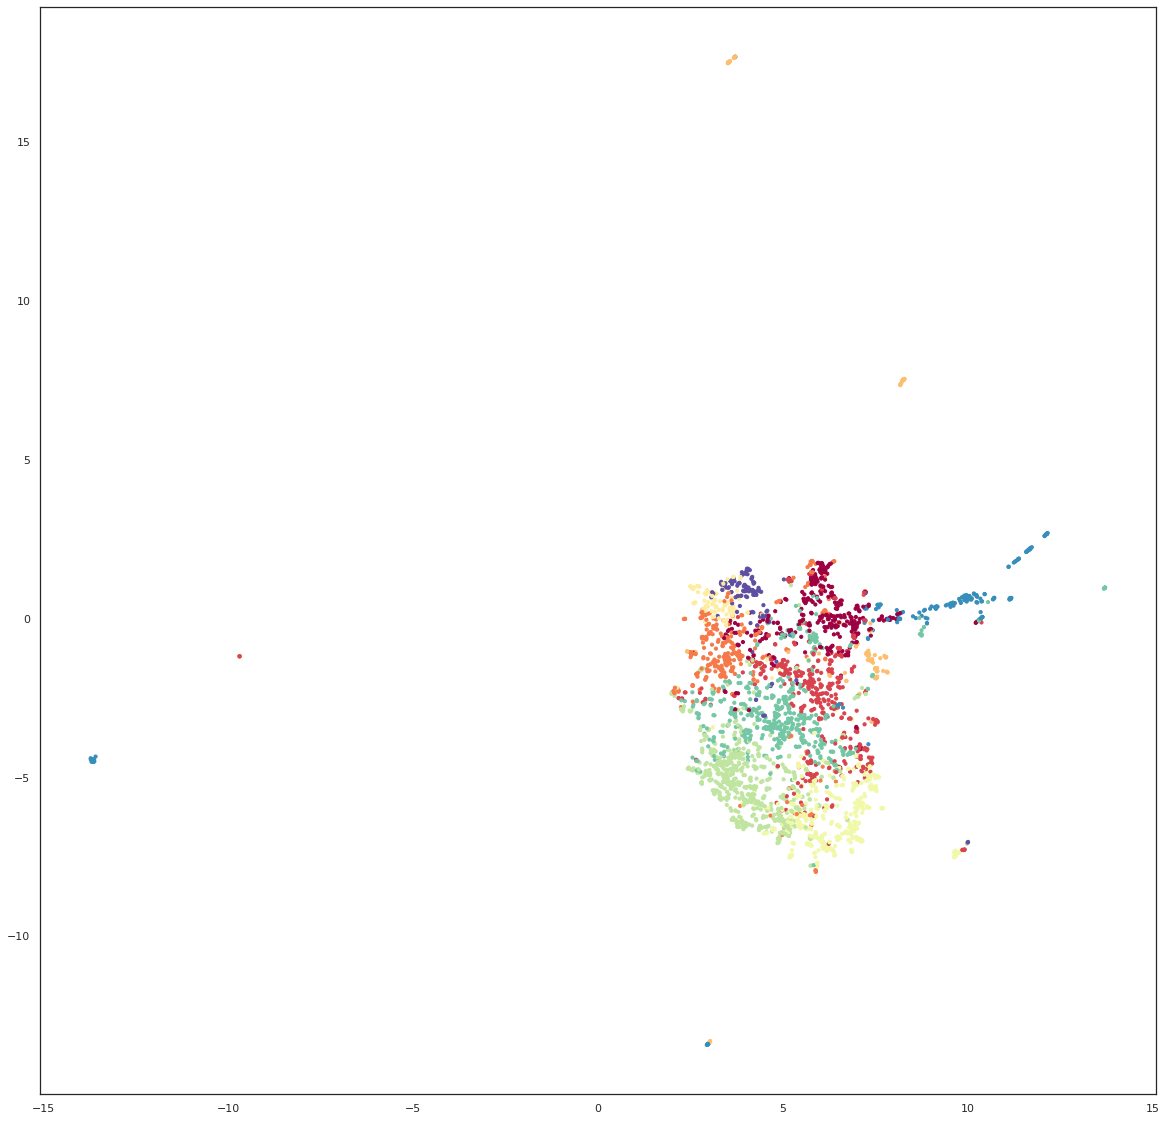

In [166]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c= plot_class.astype(int), s=10.0, cmap='Spectral')

# Information about most freq class

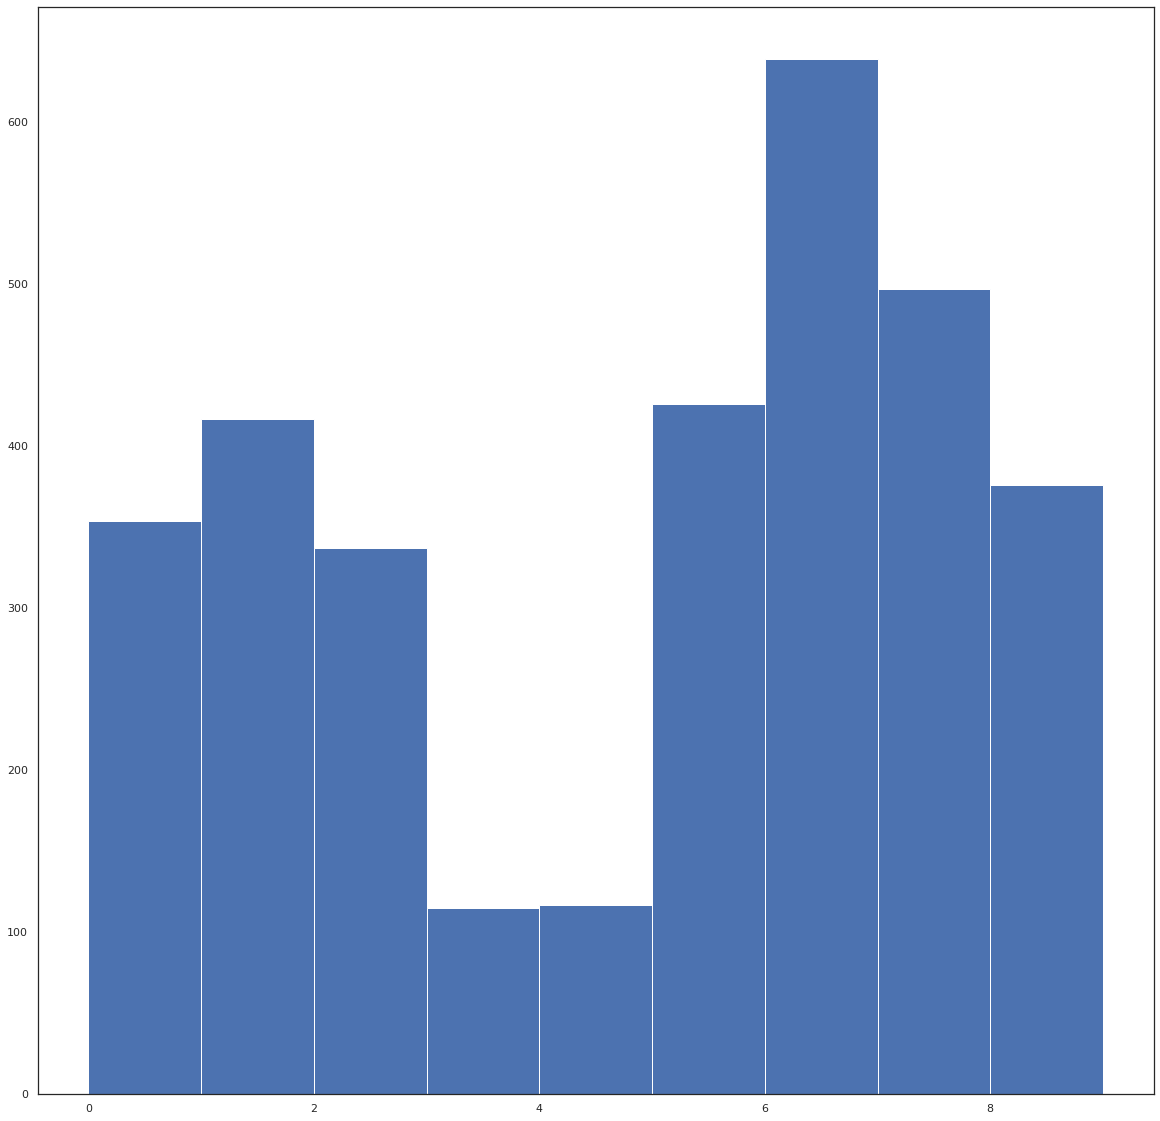

Most freq class (start from class zero): 6  with freq 0.1949359365466748   639 / 3278

 Samples in most freq class

 in her graphic content column, hillary chute looks at a reissue of howard cruse’s classic “stuck rubber baby” and a new set of tarot cards for the future. 

 what if early results in swing states on nov. 3 show president trump ahead, and he declares victory before heavily democratic mail-in votes, which he has falsely linked with fraud, are fully counted? 

 john a. macdonald was a divisive figure who tried to wipe out indigenous canadian culture. some leading politicians — including trudeau — criticized the vandalism of his statue. 



In [167]:
_, counts = np.unique(cl.cpu().numpy(), return_counts=True) # get counting of each class 
class_list = cl.cpu().numpy() 

plt.hist( class_list, bins = range(0,K))
plt.show()

most_freq_class = np.argmax(counts)
print("Most freq class (start from class zero):", most_freq_class ," with freq", counts[most_freq_class]/np.sum(counts), " " , counts[most_freq_class] ,"/", np.sum(counts)  )

index_ = (class_list == most_freq_class) # indexing the most freq class 

most_freq_text_list = np.asarray( df_abstract )[index_]
print("\n Samples in most freq class\n")
for i in range(0, min(3, len(most_freq_text_list))):
    print(most_freq_text_list[i],'\n')

In [168]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import STOPWORDS

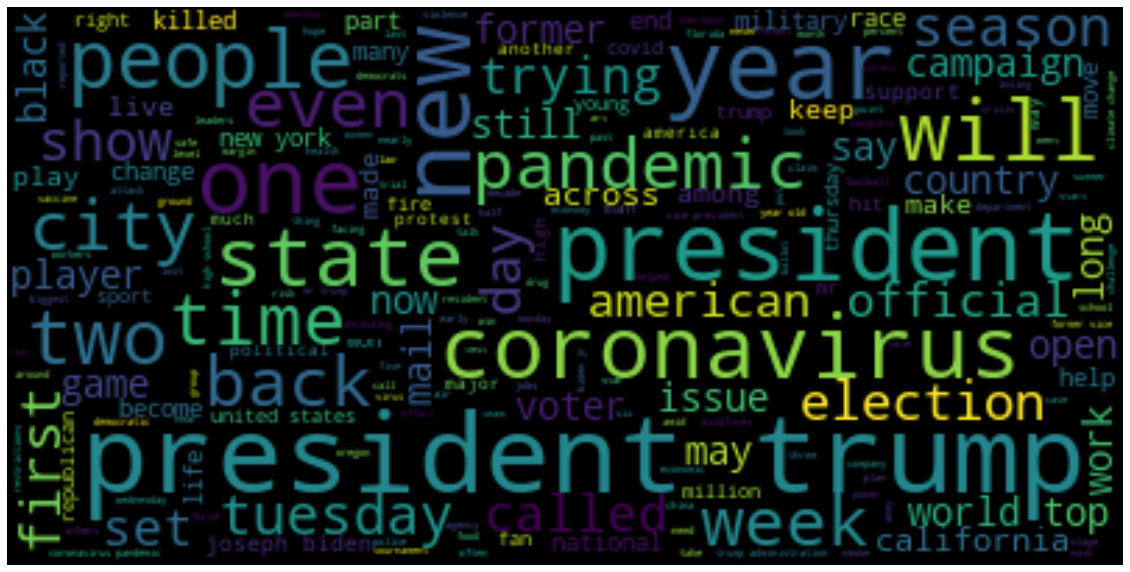

In [174]:
custom_stop_words = ["said"]
_ = [STOPWORDS.add(n) for n in custom_stop_words]

text = ""

for x in most_freq_text_list:
    text += x
    
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()